# 0.2 Single image preprocessing test

In [1]:
cd ../

/Users/anacriel/plant_seed_classification


In [2]:
import os
import cv2
import numpy as np
import src.visualization.visualize as vs
import src.features.build_features as bfeatures
from src.data.make_dataset import increase_brightness
from matplotlib import pyplot as plt

In [3]:
cd src/

/Users/anacriel/plant_seed_classification/src


In [4]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (5, 5)
#plt.style.use('dark_background')

In [5]:
data_dir = '../data/processed/'
#image_path = data_dir + 'train/Common Chickweed/c908a478e.png'
#bad case
image_path = data_dir + 'train/Common Chickweed/82561432a.png'

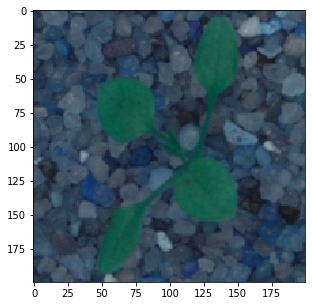

In [6]:
main_img = cv2.imread(image_path)
plt.imshow(main_img)

## Explore colors for better segmentation (not implemented yet)

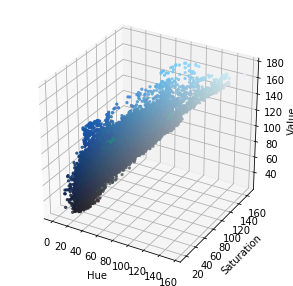

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


pixel_colors = main_img.reshape((np.shape(main_img)[0]*np.shape(main_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

h, s, v = cv2.split(main_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

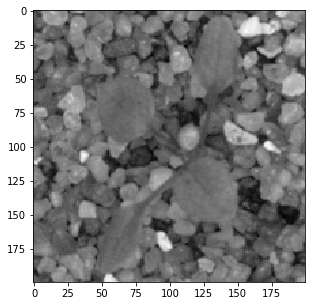

In [8]:
main_img_gs = cv2.cvtColor(main_img, cv2.COLOR_RGB2GRAY)
plt.imshow(main_img_gs, cmap='Greys_r')

## Segment image

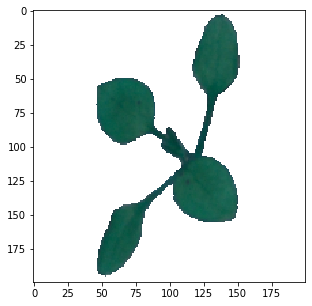

In [9]:
img_segmented, mask = vs.segment_plant(main_img)
plt.imshow(main_img)
plt.imshow(img_segmented)

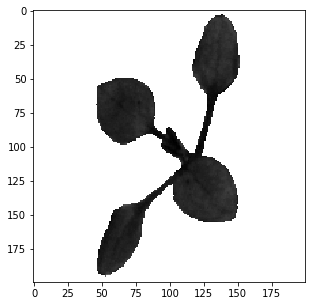

In [10]:
gs = cv2.cvtColor(img_segmented, cv2.COLOR_RGB2GRAY)
plt.imshow(gs, cmap='Greys_r')

## Adaptive image thresholding using Otsu's thresholding method

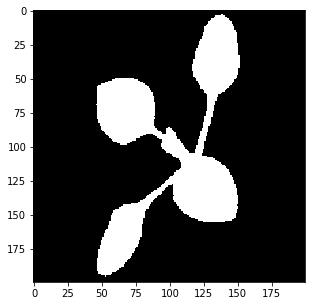

In [11]:
ret_otsu, im_bw_otsu = cv2.threshold(gs, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu, cmap='Greys_r')

## Closing holes using Morphological Transformation

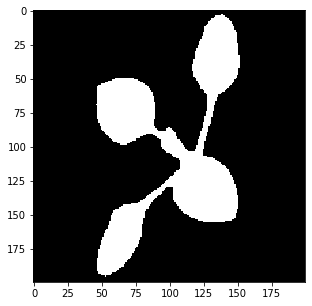

In [12]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing,cmap='Greys_r')

## Boundary extraction using contours

In [13]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

len(contours)

1

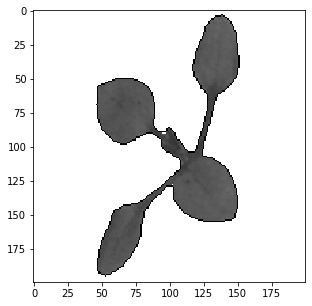

In [14]:
plottedContour = cv2.drawContours(gs,contours,-1,(0,255,0),1)
plt.imshow(plottedContour,cmap="Greys_r")

## Count features

In [15]:
cnt = contours[0]
M = cv2.moments(cnt)
M

{'m00': 6766.5,
 'm01': 672121.5,
 'm02': 82753512.08333333,
 'm03': 11377285098.85,
 'm10': 685235.0,
 'm11': 64737237.70833333,
 'm12': 7736741785.2,
 'm20': 76495415.58333333,
 'm21': 6920364616.366667,
 'm30': 9149458507.6,
 'mu02': 15991181.37140692,
 'mu03': -19515062.52770996,
 'mu11': -3327666.755200252,
 'mu12': 17476269.732290745,
 'mu20': 7102523.360618487,
 'mu21': -4004851.8952236176,
 'mu30': -35663976.2945137,
 'nu02': 0.34926283649427897,
 'nu03': -0.005181550458857848,
 'nu11': -0.07267945393372142,
 'nu12': 0.004640219487992638,
 'nu20': 0.15512596584214974,
 'nu21': -0.001063350022368018,
 'nu30': -0.009469336440564202}

In [16]:
area = cv2.contourArea(cnt)
area

6766.5

In [17]:
perimeter = cv2.arcLength(cnt,True)
perimeter

817.5950152873993

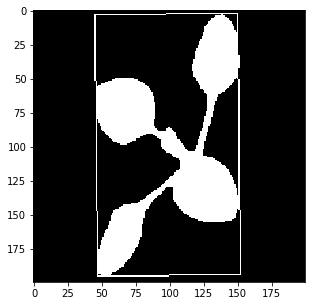

In [18]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),1)
plt.imshow(contours_im,cmap="Greys_r")

In [19]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

0.5492227979274611

In [20]:
rectangularity = w*h/area
rectangularity

3.0234242222714847

In [21]:
circularity = ((perimeter)**2)/area
circularity

98.78986315270859

In [22]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

92.81904642609985

## Color based features

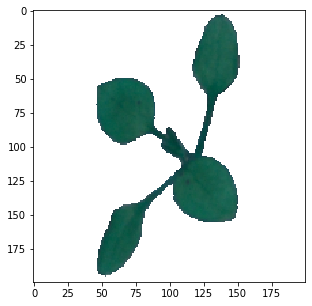

In [23]:
plt.imshow(img_segmented, cmap="Greys_r")

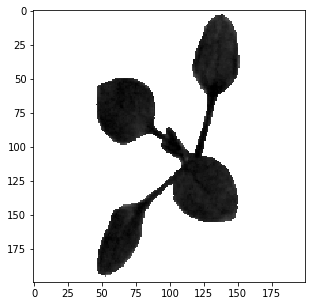

In [24]:
red_channel = img_segmented[:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

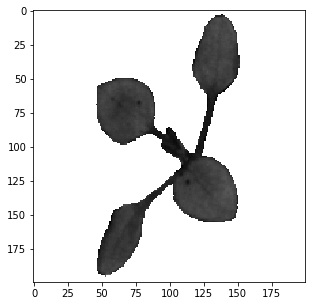

In [25]:
green_channel = img_segmented[:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

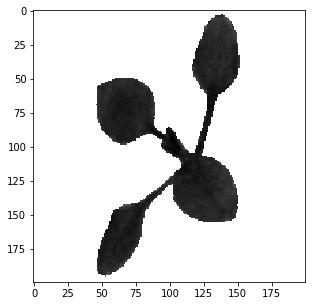

In [26]:
blue_channel = img_segmented[:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [27]:
np.mean(blue_channel)

223.078225

In [28]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [29]:
red_mean = np.mean(red_channel)
red_mean

4.0201

In [30]:
green_mean = np.mean(green_channel)
green_mean

15.642275

In [31]:
blue_mean = np.mean(blue_channel)
blue_mean

13.2961

In [32]:
red_var = np.std(red_channel)
red_var

9.745393577993656

## Texture based features

#### I have some issues with Mahotas now, but I didn't use it in the last submission

In [33]:
import mahotas as mt

ModuleNotFoundError: No module named 'mahotas'

In [90]:
textures = mt.features.haralick(gs)
ht_mean = textures.mean(axis=0)
ht_mean

array([ 6.40174230e-01,  7.46520823e+02,  9.39210771e-01,  6.13866005e+03,
        8.93613496e-01,  4.33391869e+02,  2.38081194e+04,  1.92830275e+00,
        2.29321752e+00,  2.87318170e-03,  1.03406291e+00, -6.13205833e-01,
        9.31285131e-01])

In [91]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[8]) #entropy

746.5208234009243
0.9392107706393008
2.2932175195178197
